# **<u>RICE LEAF DISEASE PREDICTION<u/>**

## PROJECT TEAM ID: PTID-CDS-DEC-24-2286

# Problem statement

* The task is to develop a deep learning-based model that can automatically classify different types of rice leaf diseases from images. The model should be able to identify whether the leaf is infected by bacterial leaf blight, brown spot, or leaf smut, which are common rice leaf diseases. By automating the classification process, this model can assist farmers, agricultural experts, and researchers in the timely identification of diseases and the implementation of preventive or corrective actions.

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Setting the constants

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=10
channels=3
epochs = 100

## Importing dataset 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
r'C:\Users\reddi\Downloads\PRCP-1001-RiceLeaf\Data',
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


## Domain analysis and Data Information

* Rice is one of the most essential staple crops worldwide, feeding over half of the global population. However, rice crops are highly vulnerable to several diseases, which can drastically reduce both the yield and quality of rice production. Three of the most common diseases affecting rice plants are bacterial leaf blight, brown spot, and leaf smut.
* This dataset contains a total of 120 images of rice leaves infected with these diseases. The images are categorized into three classes based on the type of disease, with 40 images in each class.

Classes:

* Leaf smut
* Brown spot
* Bacterial leaf blight

* Leaf smut is caused by the fungus Entyloma oryzae and is considered a less frequent disease in rice crops. It manifests as small, round, reddish-brown lesions on the leaves, which eventually darken and release powdery spores. While leaf smut generally does not result in significant yield losses, it can lower the quality of rice grains by decreasing their size and weight.

* Brown spot, caused by the fungus Cochliobolus miyabeanus, is a major threat to rice crops and can lead to considerable yield losses. The disease presents as small, oval to elliptical brown spots on the leaves with a surrounding yellow halo. When the infection becomes severe, the spots merge, causing the leaves to wither and die. Brown spot can also impact the panicles, resulting in a reduction in both the quantity and quality of the harvested rice grains.

* Bacterial leaf blight, caused by the bacterium Xanthomonas oryzae pv. oryzae, is one of the most devastating rice diseases. It is characterized by water-soaked lesions on the leaves, which eventually turn brown and dry up. In severe cases, the disease causes wilting and the death of the plant, leading to substantial reductions in rice yield.



In [4]:
#class names
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
#total batches
len(dataset)

12

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(10, 256, 256, 3)
[2 1 1 1 1 1 2 1 0 2]


#### Observations
* Each element in the dataset is a tuple. First element is a batch of 10 elements of images. Second element is a batch of 10 elements of class labels

## Data visualization

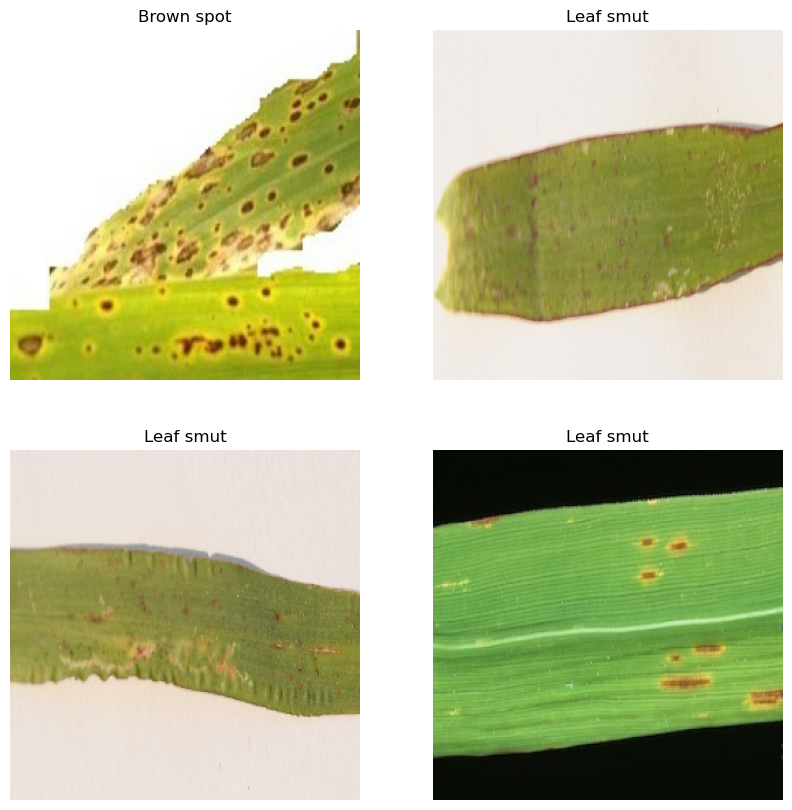

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Split the data for training, testing and validation.

In [8]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8
    val_size = 2
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [10]:
len(test_ds)

2

## Chache, shuffle and prefetch the dataset

### Catche - 
* Instead of recomputing these values for each training iteration, the CNN can access and reuse them, which significantly speeds up training. This is especially helpful in CNNs where data augmentation or complex preprocessing is involved.

### Prefetch -
* During CNN training, there are often periods where the model is computing gradients while waiting for the next batch of data to load. Prefetching allows us to start loading the next batch in the background while the model is training on the current batch. This overlapping of operations helps keep the GPU or CPU busy and can lead to faster training times.

### Shuffle - 
* If we feed the CNN consecutive batches of data that are highly correlated (e.g., all images of one class followed by another), the model may learn patterns based on this order, which can lead to poor generalization. Shuffling ensures that each batch contains a random mix of samples from different classes, making the training process more robust.

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a Layer for Resizing and Normalization

* Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

* You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [12]:
#preprocessing

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


## Data Augmentation

* Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the original images. This helps the model generalize better by making it robust to different variations of the input data.
*  In the context of our rice leaf disease image classification project, data augmentation can play a crucial role in improving the performance and robustness of our model. By generating new images with different variations such as rotations, flips, zooms, and other transformations, we can increase the diversity of our dataset and provide our model with more examples to learn from, which can lead to better classification accuracy and robustness to variations in the real-world data.

In [13]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
# Applying Data Augmentation on train dataset

train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



# Model Architecture


In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 12, 12, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (10, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 1152)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,699 (725.39 KB)

 Trainable params: 185,699 (725.39 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
* We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [18]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

In [19]:
history = model.fit(train_ds,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.3037 - loss: 1.1101 - val_accuracy: 0.3000 - val_loss: 1.1129
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.4147 - loss: 1.0842 - val_accuracy: 0.3500 - val_loss: 1.0991
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3367 - loss: 1.1031 - val_accuracy: 0.4000 - val_loss: 1.1011
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4156 - loss: 1.0926 - val_accuracy: 0.3500 - val_loss: 1.1030
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.4428 - loss: 1.0846 - val_accuracy: 0.4500 - val_loss: 1.0977
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.4233 - loss: 1.0807 - val_accuracy: 0.3000 - val_loss: 1.1282
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4274 - loss: 1.0301 - val_accuracy: 0.4000 - val_loss: 1.0694
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.4602 - loss: 1.0153 - val_accuracy: 0.3500 - v

In [20]:
score = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9667 - loss: 0.1038


In [21]:
score

[0.1434553563594818, 0.949999988079071]

## Plotting the Accuracy and Loss Curves

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 8}

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

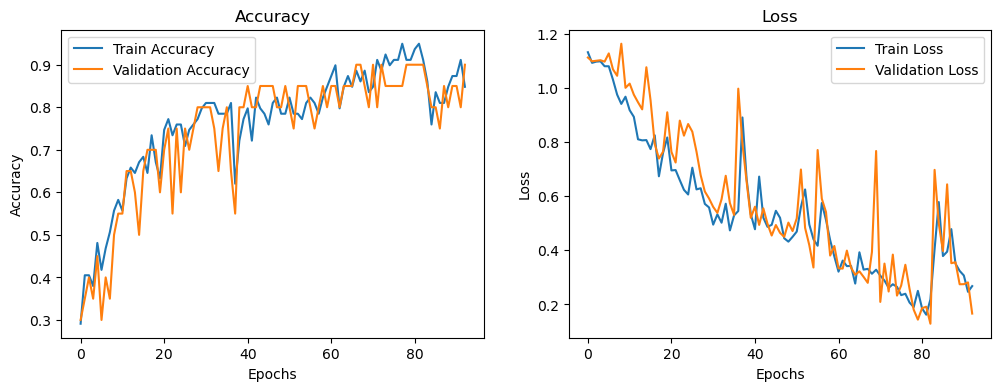

In [26]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
#Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Run prediction on a sample image

first image to predict
actual label: Leaf smut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
predicted label: Leaf smut


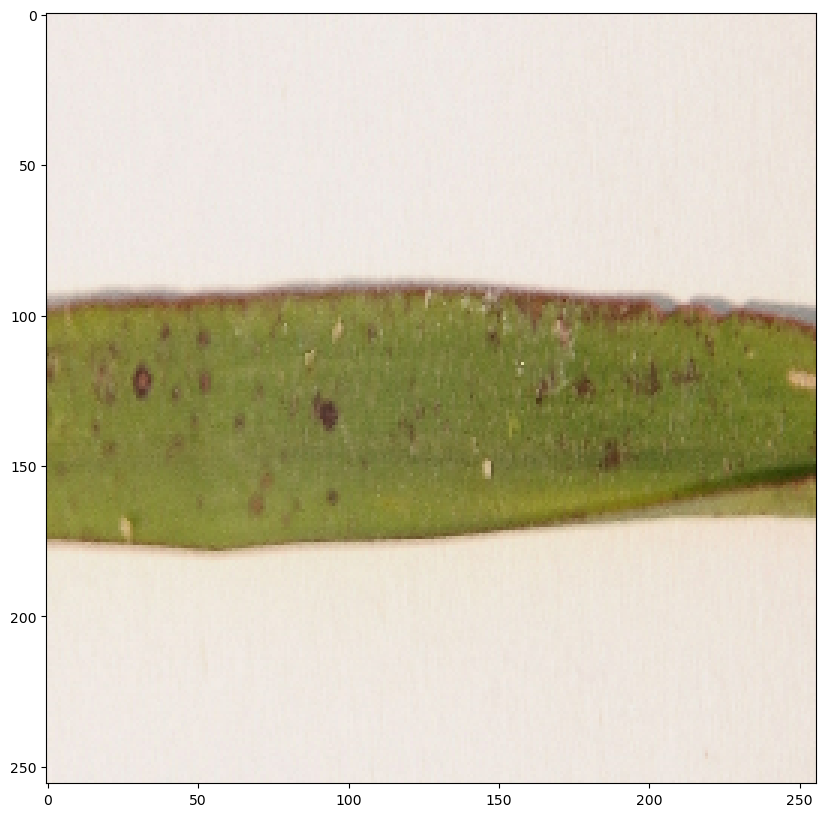

In [27]:
#prediction on sample
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Creating a function for inference

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Prediction on few Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


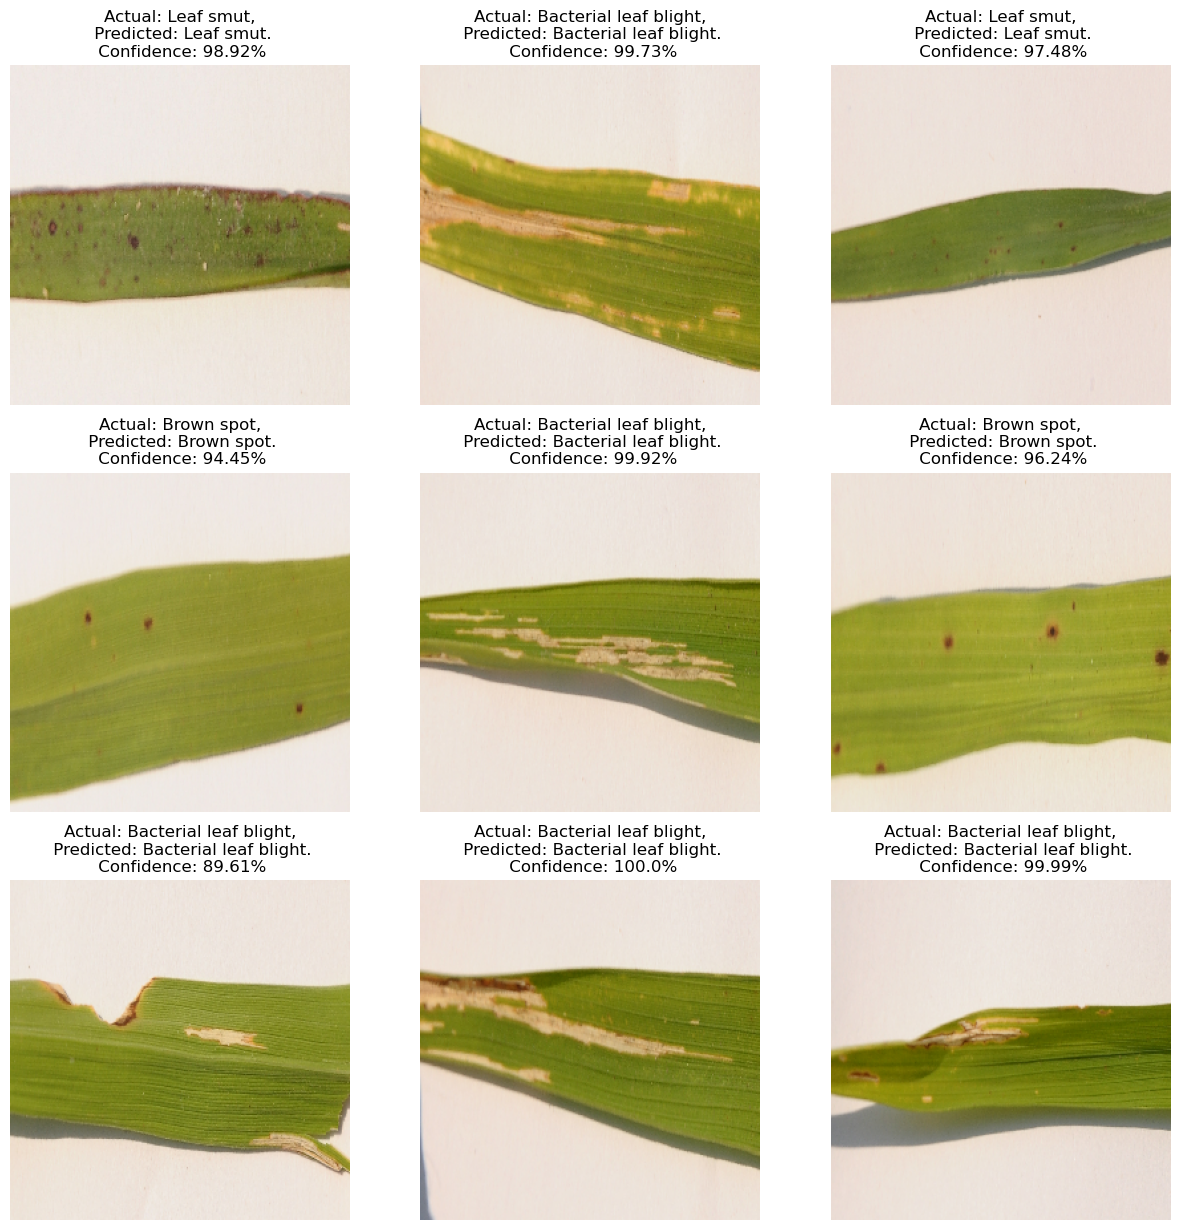

In [29]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Summary
* The project involved building a deep learning model to classify images of rice leaf disease. The dataset contained images from 3 type of rice leaf disease namely bacterial bligh, brown spot, and leaf smut. The project was divided into several steps, including data exploration, data preprocessing, building and training deep learning models, and evaluating model performance.

* During data exploration, we analyzed the dataset and visualized the images to get a better understanding of the data. We observed that the dataset was balanced, with an equal number of images for rice leaf diseases. We also noticed that the images were of different sizes and needed to be resized to a uniform size before being used for training. We have rescaled them to uniform size of 256 X 256.

* For data preprocessing, We have normalized the training dataset . We used Keras' ImageDataGenerator to generate augmented images to increase the size of the dataset and reduce overfitting. We also resized the images and divided them into training, validation, and testing sets.

* We built  deep learning models by applying transfer learning technique,  we trained model on augmented datasets and evaluated their performance using accuracy, loss, and time taken per epoch. 

# Problem Challenge - 
### Limited amount of data:
* One of the biggest challenges in the project was the limited amount of data available for training the models. We had only 119 images from 3 classes. This could lead to overfitting, where the model memorizes the training data and does not generalize well to new data. To deal with this challenge, data augmentation techniques were used to artificially increase the size of the dataset. This helped to improve the performance of the models and reduce overfitting.

### Complexity of deep learning models:
* Deep learning models can be very complex and have a large number of parameters, which makes them difficult to train and optimize. To deal with this challenge, various techniques such as regularization, and early stopping were used to prevent overfitting and improve the performance of the models.

### Hardware limitations:
* Deep learning models require a lot of computational resources, especially when training on large datasets. This can be a challenge if we don't have access to powerful hardware. To deal with this challenge, cloud computing services such as Google Colab were used to train the models, which provided access to powerful GPUs without the need for expensive hardware.